In [1]:
import os
import glob
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import getdist
import getdist.plots

import numpy as np
import scipy.stats

pi = np.pi

In [2]:
import sys
sys.path.append("../../KiDS/kcap/utils/")

import process_chains
import stat_tools

import importlib

In [3]:
import getdist.chains
getdist.chains.print_load_details = False

In [4]:
text_width = 523.5307/72
column_width = 256.0748/72

plot_settings = getdist.plots.GetDistPlotSettings()
plot_settings.figure_legend_frame = False
plot_settings.legend_frame = False
plot_settings.figure_legend_loc = "upper right"
plot_settings.alpha_filled_add=0.8
plot_settings.alpha_factor_contour_lines=0.8
plot_settings.fontsize = 10
# plot_settings.axes_fontsize = 8
#plot_settings.lab_fontsize = 8
plot_settings.legend_fontsize = 10

plot_settings.x_label_rotation = 45.0

matplotlib.rc("text", usetex=False)
# matplotlib.rc("text.latex", preamble=r"""
# \usepackage{txfonts}
# \newcommand{\mathdefault}[1][]{}""")

matplotlib.rc("font", family="Times")

plt.style.use('default')


In [5]:
def get_chain_color(chain):
    return chain.chain_def["color"]

def get_chain_label(chain):
    return chain.chain_def["label"]

def select_chains(chains, selection, global_selection=None):
    selected_chains = [None]*len(selection)
    for c in chains.values():
        for i, selection_criteria in enumerate(selection):
            matches_all_selection_criteria = all([c.chain_def[k] == v for k,v in selection_criteria.items()])
            if matches_all_selection_criteria:
                selected_chains[i] = c
    
    [selected_chains.pop(i) for i, s in enumerate(selected_chains) if s is None]
        
    return selected_chains

In [20]:
base_dir = "../runs/"

chain_def_fiducial = [
            {"root_dir" : os.path.join(base_dir, 
                                        "run0_multinest/"),
              "name"     : "run0",
              "label"    : "KiDS-1000 x tSZ (fixed dz)",
              "n_varied" : 8,
              "color"    : "C0"},
             {"root_dir" : os.path.join(base_dir, 
                                        "run1_w_dz_multinest/"),
              "name"     : "run1",
              "label"    : "KiDS-1000 x tSZ, $\\ell \\in (40,2000)$",
              "n_varied" : 13,
              "color"    : "C0"},
             {"root_dir" : os.path.join(base_dir, 
                                        "run2_w_dz_wide_cib_multinest/"),
              "name"     : "run2",
              "label"    : "KiDS-1000 x tSZ, wide $\\alpha_{\\rm CIB}$, $\\ell \\in (40,2000)$",
              "n_varied" : 13,
              "color"    : "C0"},
             {"root_dir" : os.path.join(base_dir, 
                                        "run3_ACT_BN_w_dz_no_cib_multinest/"),
              "name"     : "run3",
              "label"    : "KiDS-1000 x tSZ, ACT BN, no CIB, $\\ell \\in (100,3000)$",
              "n_varied" : 12,
              "color"    : "C0"},
              {"root_dir" : os.path.join(base_dir, 
                                        "run4_ACT_BN_w_dz_wide_cib_multinest/"),
              "name"     : "run4",
              "label"    : "KiDS-1000 x tSZ, ACT BN, wide $\\alpha_{\\rm CIB}$, $\\ell \\in (100,3000)$",
              "n_varied" : 13,
              "color"    : "C0"},
                    ]

chain_def_cosmic_shear =  [
            {"root_dir" : os.path.join(base_dir, 
                                      "cosmic_shear_run1_fixed_multinest/"),
              "name"     : "EE_run1",
              "label"    : "KiDS-1000 NaMaster, $\\ell \\in (100,1500)$",
              "n_varied" : 12,
              "color"    : "C0"},
]
chain_def_KiDS_1000 = [
            {"root_dir" : "/home/ttroester/Research/KiDS/kcap/runs/3x2pt/data_iterated_cov/cosmology/multinest_blindC_EE",
             "name"     : "EE",
             "label"    : "Cosmic shear, band powers, fiducial",
             "n_varied" : 12,
             "color"    : "C1"},
             {"root_dir" : "/home/ttroester/Research/KiDS/kcap/runs/extended_cosmologies/data/cosmology/multinest_medium_blindC_EE_HMCode2020/",
             "name"     : "EE_HMCode2020",
             "label"    : "Cosmic shear, HMCode-2020",
             "n_varied" : 12,
             "color"    : "C2"},
             {"root_dir" : "/home/ttroester/Research/KiDS/kcap/runs/extended_cosmologies/data/cosmology/multinest_medium_blindC_EE_HMx",
             "name"     : "EE_HMx",
             "label"    : "Cosmic shear, HMx",
             "n_varied" : 12,
             "color"    : "C2"},
                    ]

In [21]:
chains = {}

In [22]:
defs = [
    #  *chain_def_fiducial,
     *chain_def_cosmic_shear,
     *chain_def_KiDS_1000,
      ]

for c in defs:
    print(f"Chain {c['name']}")

    # Load chain
    chain_file = glob.glob(os.path.join(c["root_dir"], "output/samples_*.txt"))\
                    + glob.glob(os.path.join(c["root_dir"], "chain/samples_*.txt"))
    if len(chain_file) != 1:
        raise ValueError(f"Could not find unique chain file in {c['root_dir']}")
    chain_file = chain_file[0]

    value_file = os.path.join(c["root_dir"], "config/values.ini")

    s = process_chains.load_chain(chain_file, values=value_file, run_name=c["name"], 
                                  strict_mapping=False, ignore_inf=True, burn_in=c.get("burn_in", 0.5))

    param_names = [n.name for n in s.getParamNames().names]
                         
    if "omegamh2" not in param_names:
        s.addDerived(s.getParams().omegam*s.getParams().h**2,
                     name="omegamh2", label="\\Omega_{\\rm m} h^2")
    if "omeganuh2" not in param_names and "omeganu" in param_names:
        s.addDerived(s.getParams().omeganu*s.getParams().h**2,
                     name="omeganuh2", label="\\Omega_{\\nu} h^2")
    if "Sigmaalpha" not in [n.name for n in s.getParamNames().names]:
        s.addDerived(s.getParams().sigma8*(s.getParams().omegam/0.3)**0.58,
                     name="Sigmaalpha", label="\\Sigma_{8}")

    s.chain_def = c
    chains[c["name"]] = s

Chain EE_run1
Using 2980 samples out of 2980 in the chain.
Chain EE
Using 17122 samples out of 17122 in the chain.
Chain EE_HMCode2020
Using 8342 samples out of 8342 in the chain.
Chain EE_HMx


../../KiDS/kcap/utils/process_chains.py:638: UserWarning: Parameter cosmological_parameters--sigma_8_lcdm in chain does not have mapping to cosmomc format.
  warnings.warn(f"Parameter {p} in chain does not have mapping to {parameter_map} format.")
../../KiDS/kcap/utils/process_chains.py:638: UserWarning: Parameter cosmological_parameters--s_8_lcdm in chain does not have mapping to cosmomc format.
  warnings.warn(f"Parameter {p} in chain does not have mapping to {parameter_map} format.")


Using 8333 samples out of 8333 in the chain.


Plotting 2 chains (KiDS-1000 x tSZ, wide $\alpha_{\rm CIB}$, $\ell \in (40,2000)$, Cosmic shear, HMx)
Plotting parameters omegam sigma8 s8 a_ia logt_heat alpha_cib


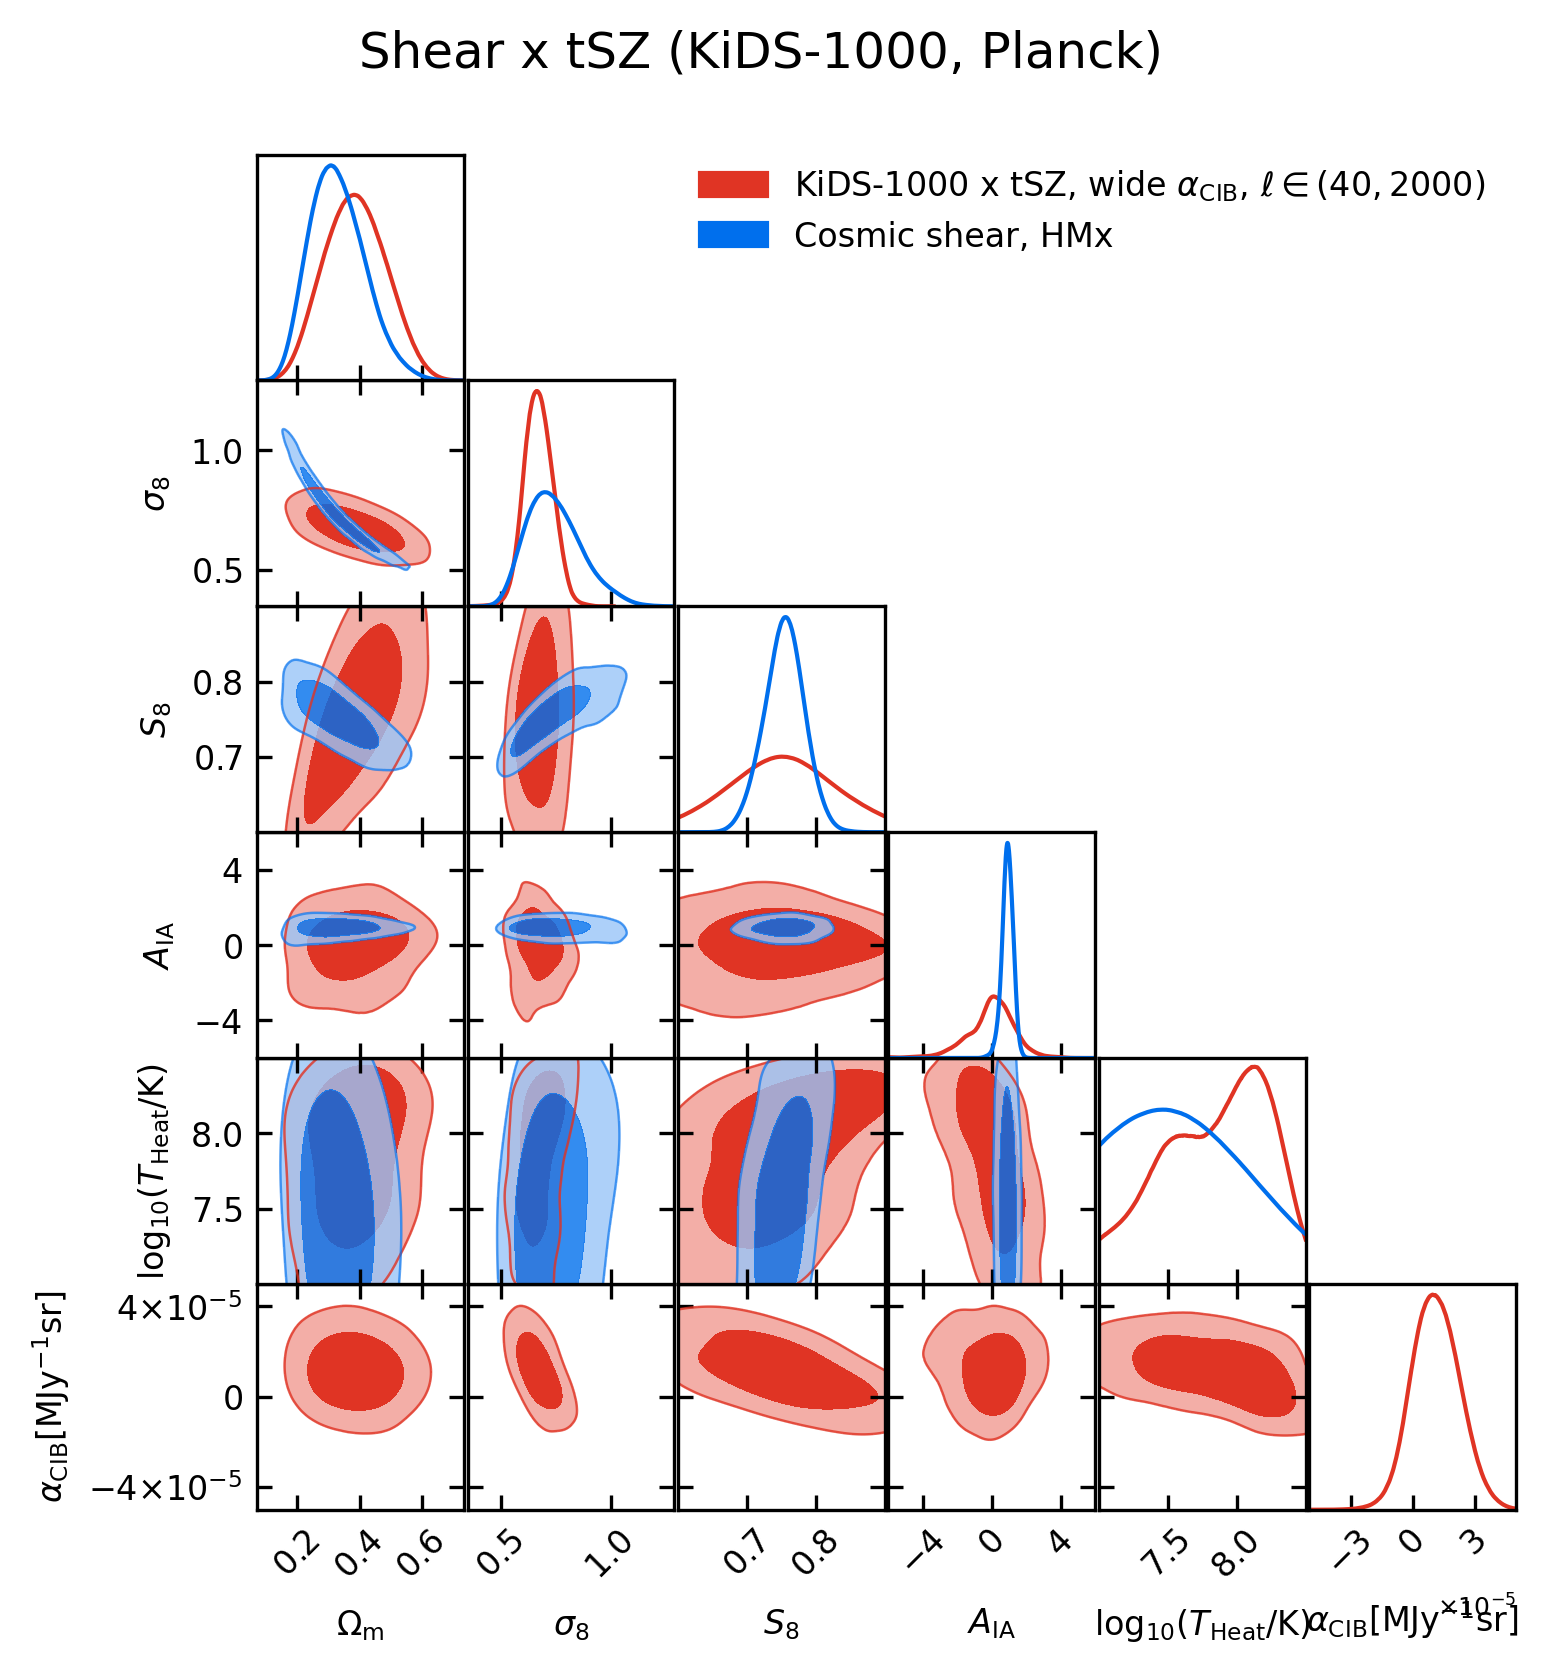

In [12]:
chain_selection = [#{"name" : "run0",},
                   #{"name" : "run2",},
                   {"name" : "run2",},
                   #{"name" : "run4",},
                   #{"name" : "EE",},
                   #{"name" : "EE_HMCode2020",},
                   {"name" : "EE_HMx",},
                  ]

chains_to_plot = select_chains(chains, chain_selection)

chain_colors = [get_chain_color(c) for c in chains_to_plot]
chain_labels = [get_chain_label(c) for c in chains_to_plot]

print(f"Plotting {len(chains_to_plot)} chains ({', '.join(chain_labels)})")

params_to_plot = ["omegam", "sigma8", "s8", "a_ia", "logt_heat", "alpha_cib"]

print(f"Plotting parameters {' '.join(params_to_plot)}")

width = 1.5*column_width
g = getdist.plots.get_subplot_plotter(width_inch=width, scaling=False,
                                      settings=copy.deepcopy(plot_settings))

g.settings.legend_fontsize = 8
g.settings.lab_fontsize = 8
g.settings.axes_fontsize = 8

g.triangle_plot(chains_to_plot,
                params=params_to_plot,
                filled_compare=True,
                #contour_colors=chain_colors,
                legend_labels=chain_labels,
                diag1d_kwargs={"normalized" : True},
                param_limits={"s8" : (0.6, 0.9)}
               )

g.fig.suptitle("Shear x tSZ (KiDS-1000, Planck)", y=1.05)
g.fig.dpi = 300
bbox = matplotlib.transforms.Bbox(((0, 0), (width, 1.1*width)))
g.fig.savefig(f"plots/KiDSxPlanck_HMx.png", bbox_inches=bbox, facecolor="w")


In [18]:
for c in chains_to_plot:
    MAP_idx = np.argmax(c.getParams().logpost)

    print(c.chain_def["label"])
    print(f"  chi2: {-2*c.loglikes[MAP_idx]:.1f}")
    print(f"  S8: {c.getParams().s8[MAP_idx]:.3f}")
    print(f"  log_theat: {c.getParams().logt_heat[MAP_idx]:.2f}")
    print(f"  alpha_CIB: {c.getParams().alpha_cib[MAP_idx]:.2f}")


KiDS-1000 x tSZ, wide $\alpha_{\rm CIB}$, $\ell \in (40,2000)$
  chi2: 25.0
  S8: 0.786
  log_theat: 8.12
  alpha_CIB: 0.00
KiDS-1000 x tSZ, ACT BN, wide $\alpha_{\rm CIB}$, $\ell \in (100,3000)$
  chi2: 40.4
  S8: 0.584
  log_theat: 7.76
  alpha_CIB: 0.00
Cosmic shear, HMx
  chi2: 150.9
  S8: 0.763
  log_theat: 7.20


AttributeError: 'ParSamples' object has no attribute 'alpha_cib'

Plotting 2 chains (KiDS-1000 NaMaster, $\ell \in (100,1500)$, Cosmic shear, band powers, fiducial)
Plotting parameters omegam sigma8 s8 a_ia a_baryon


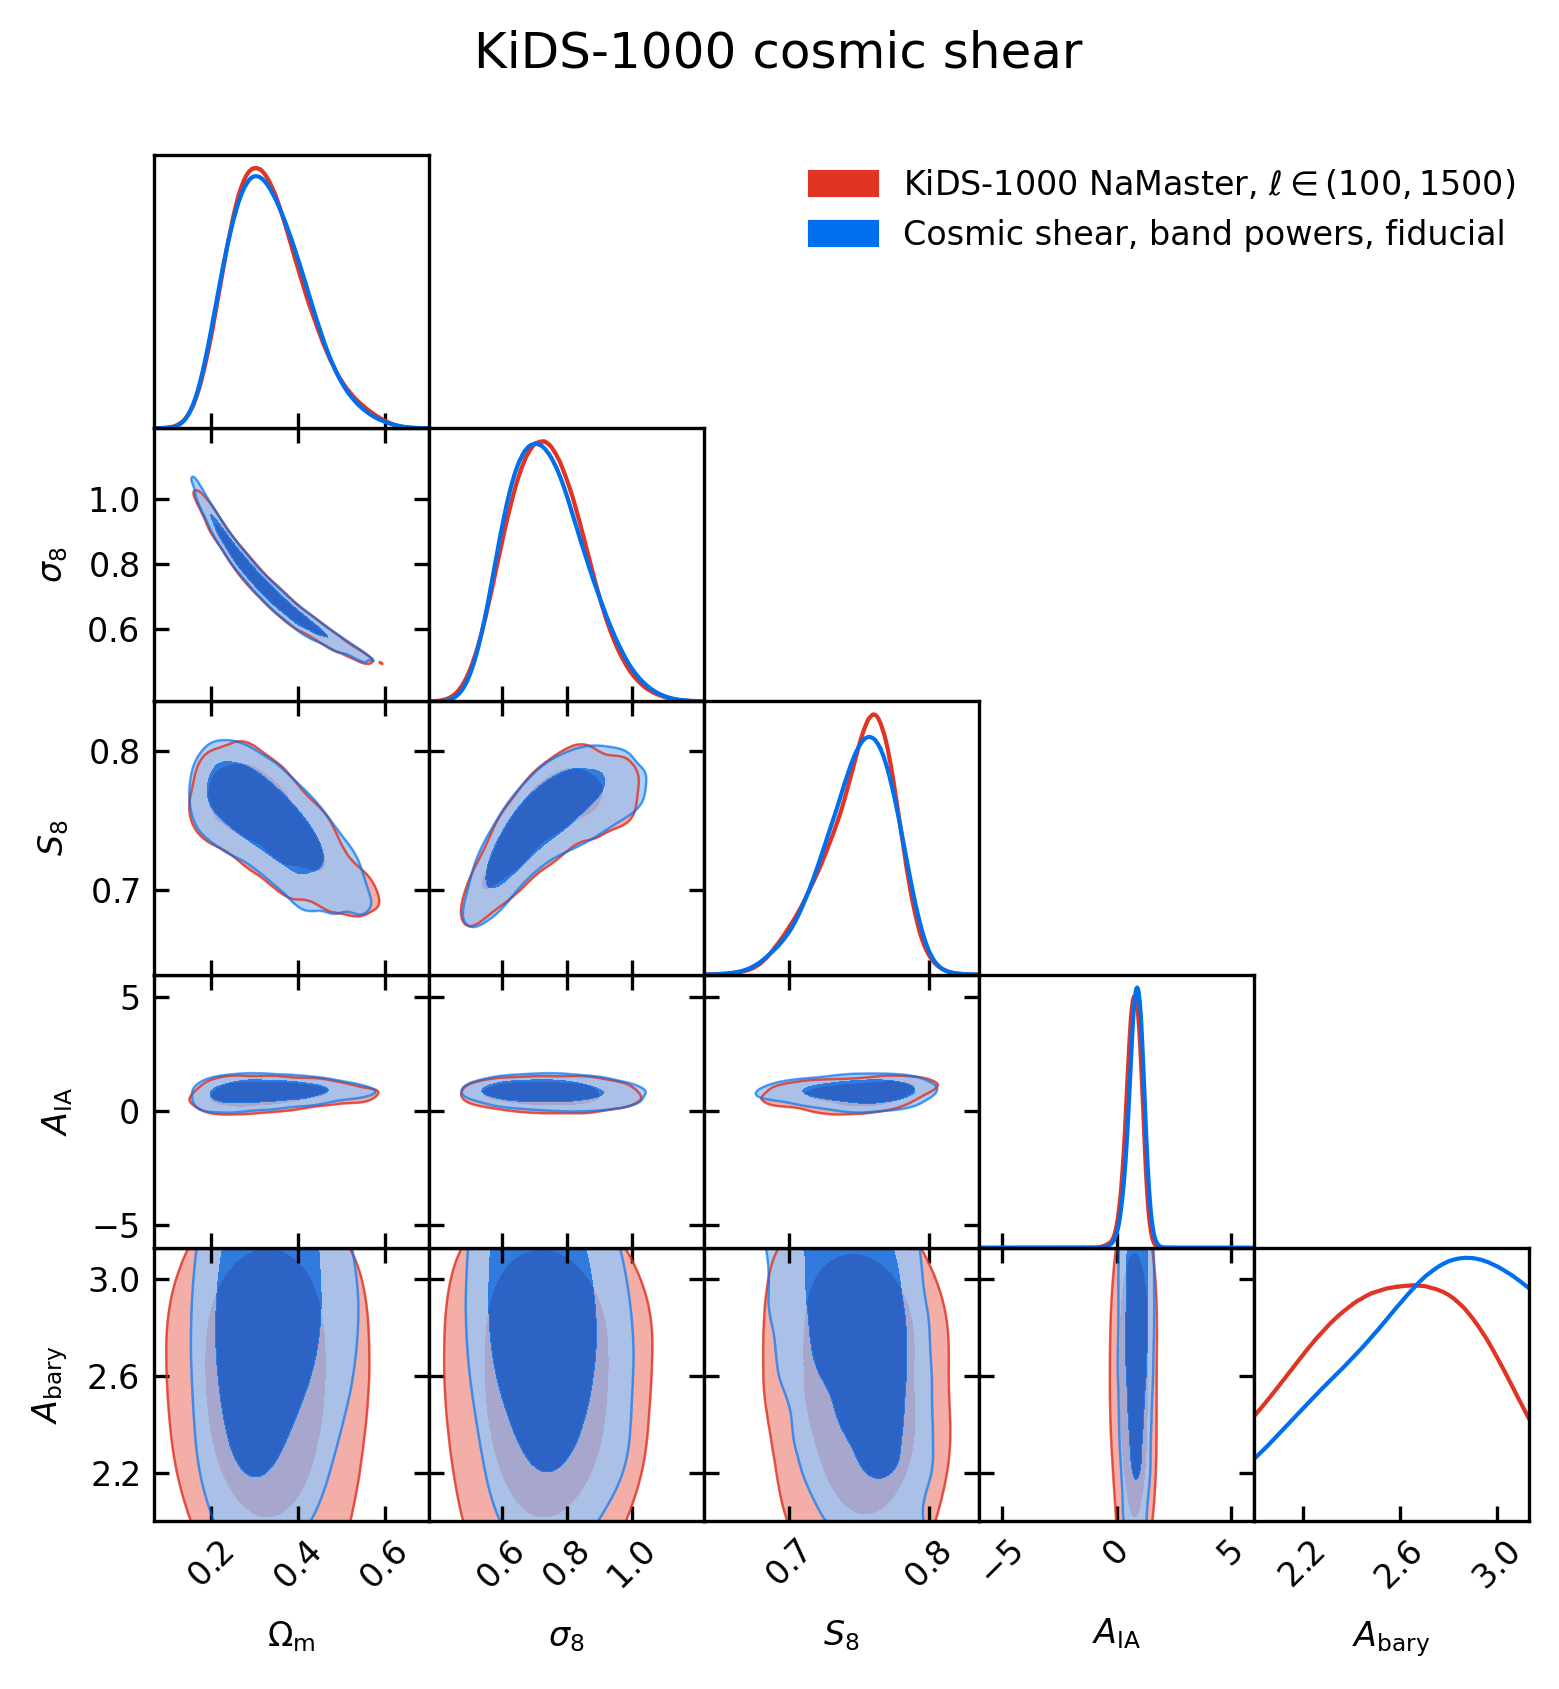

In [23]:
chain_selection = [{"name" : "EE_run1"},
                   {"name" : "EE",},
                  
                  ]

chains_to_plot = select_chains(chains, chain_selection)

chain_colors = [get_chain_color(c) for c in chains_to_plot]
chain_labels = [get_chain_label(c) for c in chains_to_plot]

print(f"Plotting {len(chains_to_plot)} chains ({', '.join(chain_labels)})")

params_to_plot = ["omegam", "sigma8", "s8", "a_ia", "a_baryon",]

print(f"Plotting parameters {' '.join(params_to_plot)}")

width = 1.5*column_width
g = getdist.plots.get_subplot_plotter(width_inch=width, scaling=False,
                                      settings=copy.deepcopy(plot_settings))

g.settings.legend_fontsize = 8
g.settings.lab_fontsize = 8
g.settings.axes_fontsize = 8

g.triangle_plot(chains_to_plot,
                params=params_to_plot,
                filled_compare=True,
                #contour_colors=chain_colors,
                legend_labels=chain_labels,
                diag1d_kwargs={"normalized" : True},
                # param_limits={"s8" : (0.6, 0.9)}
               )

g.fig.suptitle("KiDS-1000 cosmic shear", y=1.05)
g.fig.dpi = 300
bbox = matplotlib.transforms.Bbox(((0, 0), (width, 1.1*width)))
g.fig.savefig(f"plots/KiDS_NaMaster_gaussian_cov.png", bbox_inches=bbox, facecolor="w")


# Data vector
## Cosmic shear

In [35]:
n_z_bin = 5
n_ell_bin_bp = 8
n_ell_bin = 12

field_idx_EE = [(i, j) for i in range(n_z_bin)
                for j in range(i+1)]
field_idx_TE = [(i, 0) for i in range(n_z_bin)]

ell = {"EE": np.loadtxt("../results/measurements/shear_KiDS1000_shear_KiDS1000/likelihood/Cl_EE_gal.txt", usecols=[0]),
       "TE": np.loadtxt("../results/measurements/shear_KiDS1000_y_milca/likelihood/Cl_TE_gal.txt", usecols=[0])}
ell["BB"] = ell["EE"]
ell["TB"] = ell["TE"]

Cl = {"EE": np.loadtxt("../results/measurements/shear_KiDS1000_shear_KiDS1000/likelihood/Cl_EE_gal.txt")[:, 1:],
      "BB": np.loadtxt("../results/measurements/shear_KiDS1000_shear_KiDS1000/likelihood/Cl_BB_gal.txt")[:, 1:],
      "TE": np.loadtxt("../results/measurements/shear_KiDS1000_y_milca/likelihood/Cl_TE_gal.txt")[:, 1:],
      "TB": np.loadtxt("../results/measurements/shear_KiDS1000_y_milca/likelihood/Cl_TB_gal.txt")[:, 1:]}

Cl_err = {"EE": np.sqrt(np.diag(np.loadtxt("../results/measurements/shear_KiDS1000_shear_KiDS1000/likelihood/covariance_gaussian_EE.txt"))).reshape(-1, n_ell_bin).T,
          "BB": np.sqrt(np.diag(np.loadtxt("../results/measurements/shear_KiDS1000_shear_KiDS1000/likelihood/covariance_gaussian_BB.txt"))).reshape(-1, n_ell_bin).T,
          "TE": np.sqrt(np.diag(np.loadtxt("../results/measurements/shear_KiDS1000_y_milca/likelihood/covariance_gaussian_TE.txt"))).reshape(-1, n_ell_bin).T,
          "TB": np.sqrt(np.diag(np.loadtxt("../results/measurements/shear_KiDS1000_y_milca/likelihood/covariance_gaussian_TB.txt"))).reshape(-1, n_ell_bin).T,}

Cl["bp_EE"] = np.zeros((n_ell_bin_bp, len(field_idx_EE)))
Cl["bp_BB"] = np.zeros((n_ell_bin_bp, len(field_idx_EE)))
Cl_err["bp_EE"] = np.zeros((n_ell_bin_bp, len(field_idx_EE)))
Cl_err["bp_BB"] = np.zeros((n_ell_bin_bp, len(field_idx_EE)))

for i, idx in enumerate(field_idx_EE):
    (ell["bp"], Cl["bp_EE"][:, i], Cl_err["bp_EE"][:, i],
     Cl["bp_BB"][:, i], Cl_err["bp_BB"][:, i]) = np.loadtxt("../../KiDS/Cat_to_Obs_K1000_P1/data/Data_Plots/"
                                 "Pkk/Pkk_data/xi2bandpow_output_K1000_ALL_BLIND_C_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid_nbins_8_Ell_100.0_1500.0_"
                                 f"zbins_{idx[1]+1}_{idx[0]+1}.dat",
                                 unpack=True)

Cl["spice_TE"] = np.loadtxt("../runs/run2_w_dz_wide_cib_multinest/data/tSZ_like/shear_y_KiDS1000_milca_TE.txt")[:, 1:]
ell["spice"] = np.loadtxt("../runs/run2_w_dz_wide_cib_multinest/data/tSZ_like/shear_y_KiDS1000_milca_TE.txt")[:, 0]
Cl["old_TE"] = np.loadtxt("../results/measurements/shear_KiDS1000_y_milca_namaster/Cl_decoupled.txt")[:, 1::2]
Cl["old_TB"] = np.loadtxt("../results/measurements/shear_KiDS1000_y_milca_namaster/Cl_decoupled.txt")[:, 2::2]
ell["old"] = np.loadtxt("../results/measurements/shear_KiDS1000_y_milca_namaster/Cl_decoupled.txt")[:, 0]

mask_nmt = [False]*2 + [True]*8 + [False]*2


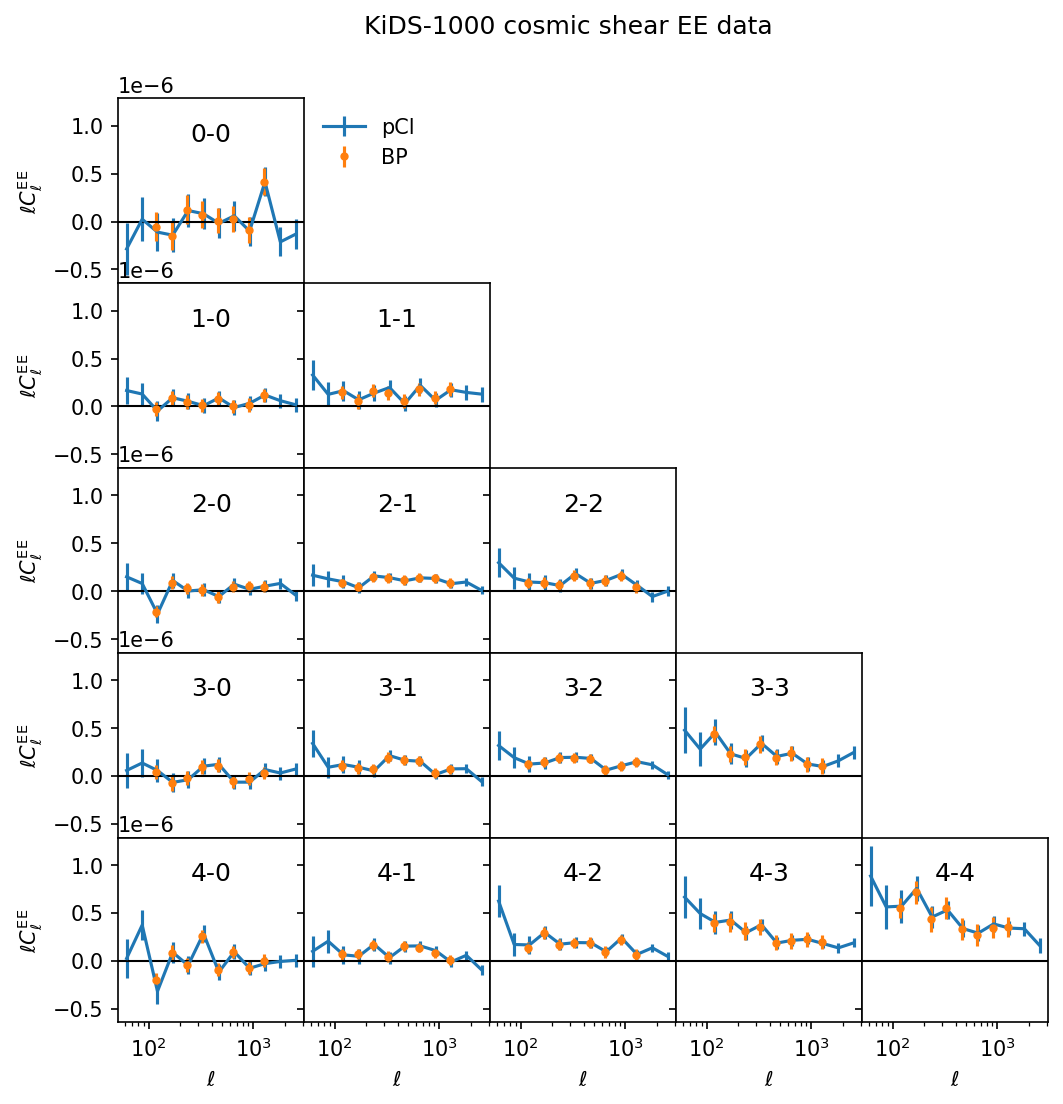

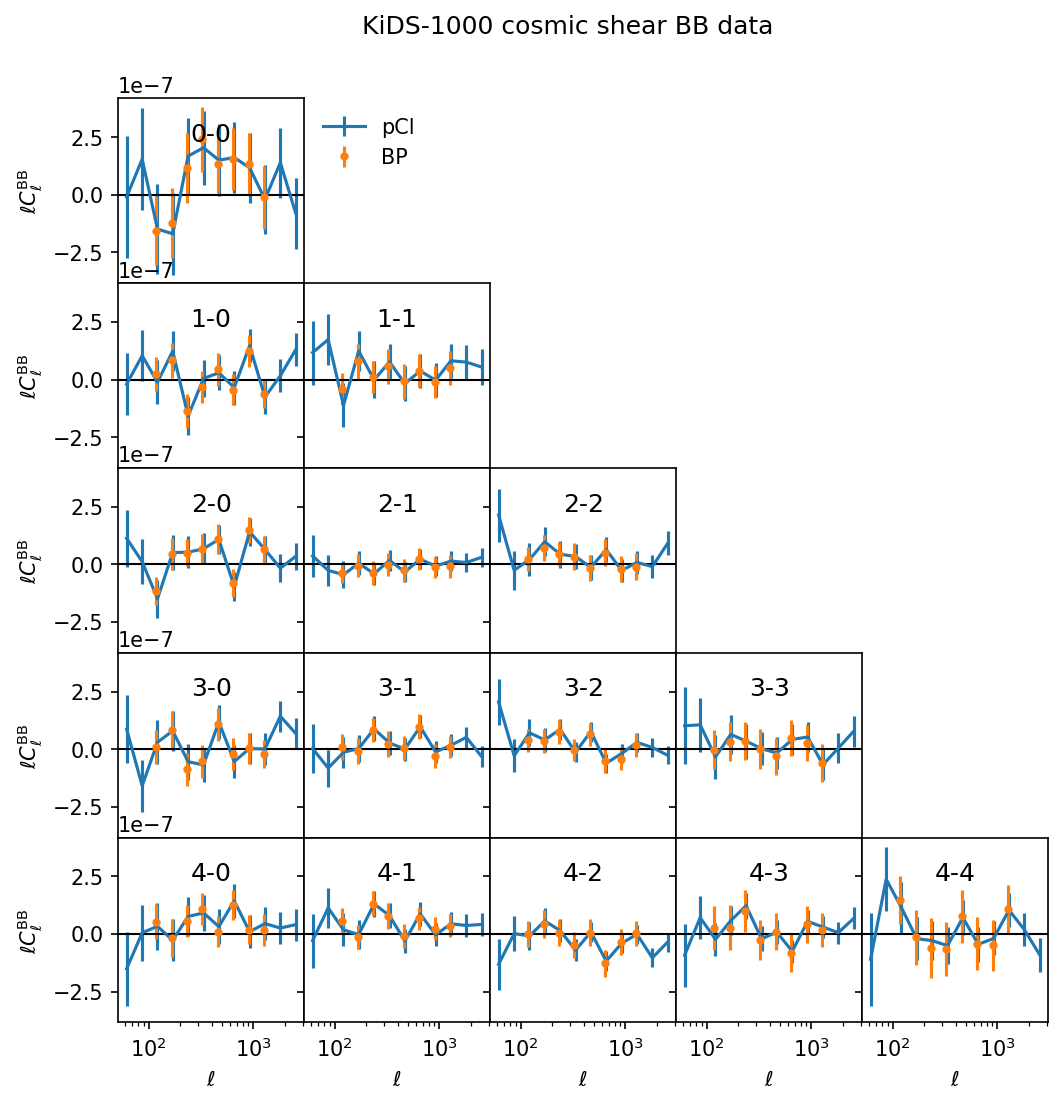

In [22]:
def plot_cosmic_shear(bandpowers=True, probe="EE"):
    fig, ax = plt.subplots(n_z_bin, n_z_bin, sharex=True, sharey=True, figsize=(8, 8))
    fig.subplots_adjust(hspace=0, wspace=0)

    for i, idx in enumerate(field_idx_EE):
        ax[idx].axhline(0, c="k", lw=1)

        x = ell[probe]
        u = x
        y = Cl[probe][:, i]
        y_err = Cl_err[probe][:, i]
        ax[idx].errorbar(x, u*y, u*y_err, label="pCl")

        x = ell["bp"]
        u = 1/x
        y = Cl[f"bp_{probe}"][:,i]
        y_err = Cl_err[f"bp_{probe}"][:,i]
        ax[idx].errorbar(x, u*y, u*y_err, ls="none", marker=".", label="BP")

        ax[idx].set_title(f"{idx[0]}-{idx[1]}", y=0.7)

        if idx[0] != idx[1]:
            ax[idx[::-1]].axis("off")

    [a.set_xlabel(r"$\ell$") for a in ax[-1]]
    [a.set_ylabel(r"$\ell C^{\rm " + probe + r"}_\ell$") for a in ax[:,0]]

    ax[0,0].set_xscale("log")
    ax[0,0].legend(loc=2, frameon=False, bbox_to_anchor=(1,1))

    fig.suptitle(f"KiDS-1000 cosmic shear {probe} data", y=0.95)
    fig.dpi = 150
    # fig.savefig("plots/nmt_vs_bp.png")

plot_cosmic_shear(probe="EE")
plot_cosmic_shear(probe="BB")

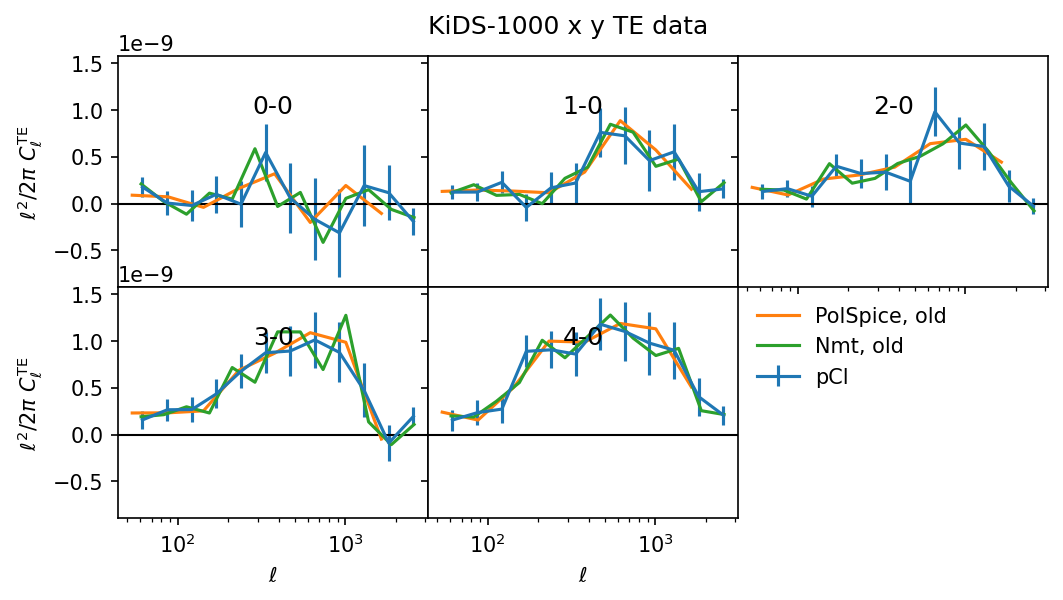

In [36]:
def plot_xcorr(probe="TE"):
    fig, ax = plt.subplots(2, n_z_bin//2+1, sharex=True, sharey=True, figsize=(8, 4))
    fig.subplots_adjust(hspace=0, wspace=0)

    for i, idx in enumerate(field_idx_TE):
        a = ax.flat[i]

        a.axhline(0, c="k", lw=1)

        x = ell[probe]
        u = x**2/(2*np.pi)
        y = Cl[probe][:, i]
        y_err = Cl_err[probe][:, i]
        a.errorbar(x, u*y, u*y_err, label="pCl")

        x = ell["spice"]
        u = x**2/(2*np.pi)
        y = Cl[f"spice_{probe}"][:, i]
        a.plot(x, u*y, label="PolSpice, old")

        x = ell["old"]
        u = x**2/(2*np.pi)
        y = Cl[f"old_{probe}"][:, i]
        a.plot(x, u*y, label="Nmt, old")

        a.set_title(f"{idx[0]}-{idx[1]}", y=0.7)

    for a in ax.flat[len(field_idx_TE):]:
        a.axis("off")

    [a.set_xlabel(r"$\ell$") for a in ax[-1]]
    [a.set_ylabel(r"$\ell^2/2\pi\ C^{\rm " + probe + r"}_\ell$") for a in ax[:,0]]

    ax[0,0].set_xscale("log")
    ax.flat[len(field_idx_TE)-1].legend(loc=2, frameon=False, bbox_to_anchor=(1,1))

    fig.suptitle(f"KiDS-1000 x y {probe} data", y=0.95)
    fig.dpi = 150
    # fig.savefig("plots/nmt_vs_bp.png")

plot_xcorr(probe="TE")
# plot_xcorr(probe="TB")

In [13]:
n_z_bin = 5

Cl_bp = np.zeros((8, 15))
Cl_bp_err = np.zeros((8, 15))

Cl_nmt_gal = np.zeros((8, 15))
Cl_nmt_gal_no_flip = np.zeros((8, 15))
Cl_nmt_gal_pre_flip_e1 = np.zeros((8, 15))
Cl_nmt_cel = np.zeros((8, 15))

field_idx = [(i, j) for i in range(n_z_bin)
             for j in range(i+1)]
for i, idx in enumerate(field_idx):
    ell_bp, Cl, err = np.loadtxt("../../KiDS/Cat_to_Obs_K1000_P1/data/Data_Plots/"
                                 "Pkk/Pkk_data/xi2bandpow_output_K1000_ALL_BLIND_C_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid_nbins_8_Ell_100.0_1500.0_"
                                 f"zbins_{idx[1]+1}_{idx[0]+1}.dat",
                                 unpack=True, usecols=[0,1,2])
    Cl_bp[:, i] = Cl
    Cl_bp_err[:, i] = err

    ell_nmt_gal = np.load(f"../results/measurements/shear_KiDS1000_shear_KiDS1000_gal_no_flip/data/Cl_gal_{idx[0]}-{idx[1]}.npz")["ell_eff"][2:-2]
    Cl_nmt_gal_no_flip[:, i] = np.load(f"../results/measurements/shear_KiDS1000_shear_KiDS1000_gal_no_flip/data/Cl_gal_{idx[0]}-{idx[1]}.npz")["Cl_decoupled"][0, 2:-2]
    Cl_nmt_gal[:, i] = np.load(f"../results/measurements/shear_KiDS1000_shear_KiDS1000/data/Cl_gal_{idx[0]}-{idx[1]}.npz")["Cl_decoupled"][0, 2:-2]
    Cl_nmt_cel[:, i] = np.load(f"../results/measurements/shear_KiDS1000_shear_KiDS1000_cel/data/Cl_gal_{idx[0]}-{idx[1]}.npz")["Cl_decoupled"][0, 2:-2]
    if i == 14:
        Cl_nmt_gal_pre_flip_e1[:, i] = np.load(f"../results/measurements/shear_KiDS1000_shear_KiDS1000_gal_pre_flip_e1/data/Cl_gal_{idx[0]}-{idx[1]}.npz")["Cl_decoupled"][0, 2:-2]

d = np.loadtxt("../runs/cosmic_shear_run0_multinest/data/like/Cl_EE_gal.txt")
ell_nmt = d[:, 0]
Cl_nmt = d[:, 1:]
cov_nmt = np.loadtxt("../runs/cosmic_shear_run0_multinest/data/like/covariance_gaussian_CCL_EE.txt")
mask_nmt = [False]*2 + [True]*9 + [False]*2

Cl_like_data = np.loadtxt("../runs/cosmic_shear_run0_multinest/output/data_block/data_vector/cosmic_shear_like_data_vector.txt")
Cl_like_theory = np.loadtxt("../runs/cosmic_shear_run0_multinest/output/data_block/data_vector/cosmic_shear_like_theory_vector.txt")
var_like = np.diag(np.loadtxt("../runs/cosmic_shear_run0_multinest/output/data_block/data_vector/cosmic_shear_like_covariance.txt"))

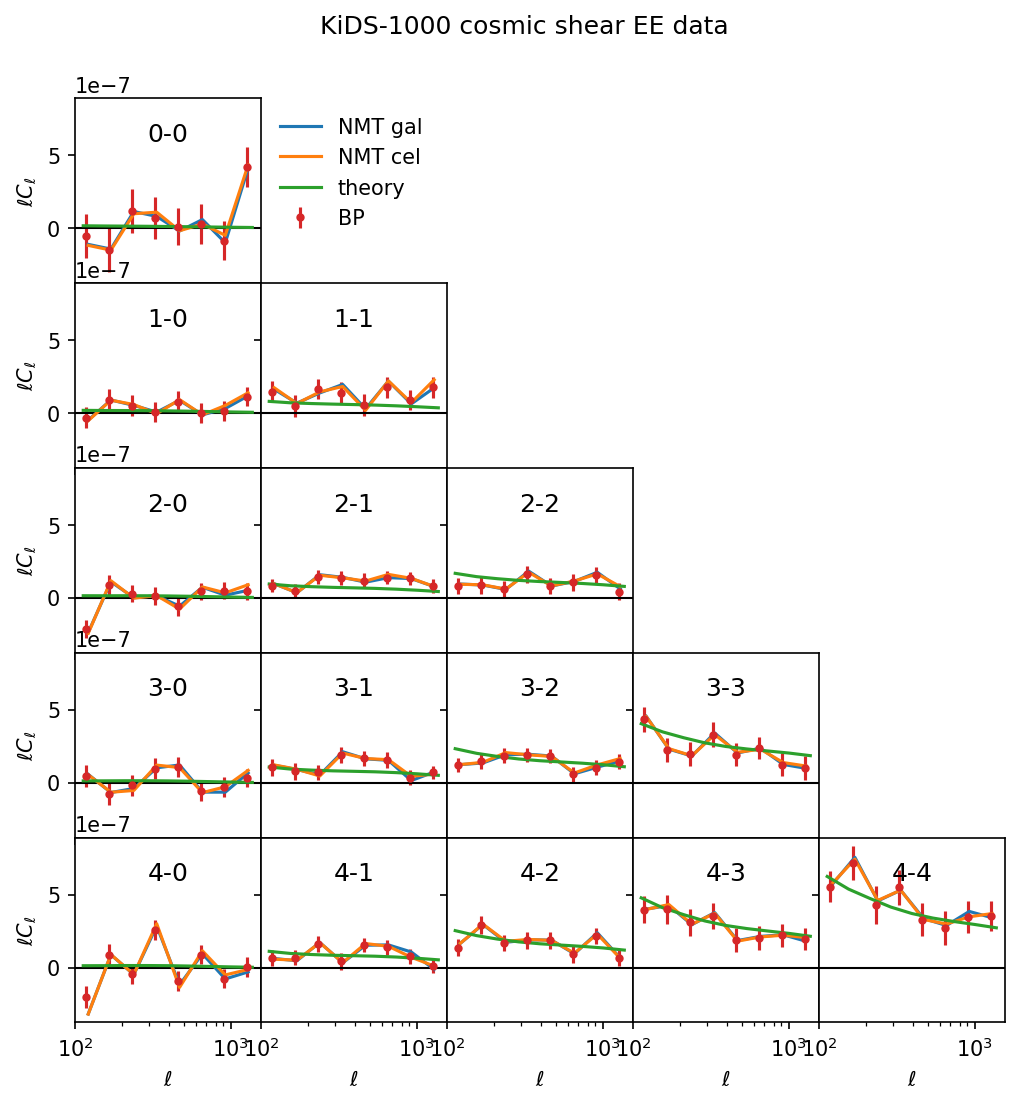

In [19]:

fig, ax = plt.subplots(n_z_bin, n_z_bin, sharex=True, sharey=True, figsize=(8, 8))
fig.subplots_adjust(hspace=0, wspace=0)

field_idx = [(i, j) for i in range(n_z_bin)
             for j in range(i+1)]

for i, idx in enumerate(field_idx):
    ax[idx].axhline(0, c="k", lw=1)

    ell = ell_nmt_gal
    u = ell#/(2*np.pi)

    Cl = Cl_nmt_gal[:, i]
    ax[idx].plot(ell, u*Cl, label="NMT gal")
    # Cl = Cl_nmt_gal_no_flip[:, i]
    # ax[idx].plot(ell, u*Cl, label="NMT gal no flip")
    # if i == 14:
    #     Cl = Cl_nmt_gal_pre_flip_e1[:, i]
    #     ax[idx].plot(ell, u*Cl, ls=":", label="NMT gal pre flip e1")
    Cl = Cl_nmt_cel[:, i]
    ax[idx].plot(ell, u*Cl, label="NMT cel")

    ell = ell_nmt[mask_nmt]
    u = ell#/(2*np.pi)

    # Cl = Cl_nmt[mask_nmt, i]
    # err = np.sqrt(np.diag(cov_nmt)[i*13:(i+1)*13][mask_nmt])
    # ax[idx].errorbar(ell, u*Cl, u*err, label="data")

    Cl = Cl_like_theory[i*9:(i+1)*9]
    ax[idx].plot(ell, u*Cl, label="theory")

    # Cl = Cl_like_data[i*9:(i+1)*9]
    # err = np.sqrt(var_like[i*9:(i+1)*9])
    # ax[idx].errorbar(ell, u*Cl, u*err, ls="none", marker=".", label="like data")

    ell = ell_bp
    u = 1/ell
    Cl = Cl_bp[:,i]
    err = Cl_bp_err[:, i]
    ax[idx].errorbar(ell, u*Cl, u*err, ls="none", marker=".", label="BP")


    ax[idx].set_title(f"{idx[0]}-{idx[1]}", y=0.7)

    if idx[0] != idx[1]:
        ax[idx[::-1]].axis("off")

[a.set_xlabel(r"$\ell$") for a in ax[-1]]
[a.set_ylabel(r"$\ell C_\ell$") for a in ax[:,0]]

ax[0,0].set_xscale("log")
ax[0,0].legend(loc=2, frameon=False, bbox_to_anchor=(1,1))

fig.suptitle("KiDS-1000 cosmic shear EE data", y=0.95)
fig.dpi = 150
fig.savefig("plots/nmt_vs_bp.png")

# Check cel to gal transform

In [1]:
import healpy as hp

In [55]:
cat_cel = np.load("../data/shear_catalogs_KiDS1000/KiDS-1000_All_z0.9-1.2.npz")
cat_gal = np.load("../data/shear_catalogs_KiDS1000/KiDS-1000_All_z0.9-1.2_galactic.npz")

In [9]:
import pylenspice.pylenspice as pylenspice


In [56]:
l_pls, b_pls, alpha_pls = pylenspice.cel2gal(cat_cel["ra"], cat_cel["dec"])

In [57]:
r = hp.Rotator(coord=["C", "G"])

In [58]:
# theta_gal, phi_gal = r(-cat_cel["dec"]/180*np.pi+np.pi/2, cat_cel["ra"]/180*np.pi)
# l = phi_gal
# b = -(theta_gal - np.pi/2)
# alpha = r.angle_ref(-cat_cel["dec"]/180*np.pi+np.pi/2, cat_cel["ra"]/180*np.pi)

l, b = r(cat_cel["ra"], cat_cel["dec"], lonlat=True)
alpha = r.angle_ref(cat_cel["ra"], cat_cel["dec"], lonlat=True)


In [59]:
alpha, alpha_pls

(array([ 1.04148463,  1.04572754,  1.04595336, ..., -2.44068126,
        -2.44240339, -2.44749616]),
 array([5.24170071, 5.2374578 , 5.23723199, ..., 2.44068145, 2.44240358,
        2.44749636]))

In [60]:
e1, e2 = -cat_cel["e1"], cat_cel["e2"]
e = np.sqrt(e1**2 + e2**2)
phi = np.arctan2(e2, e1)/2

np.allclose(e*np.cos(2*phi), e1, rtol=1e-3, atol=1e-3), np.allclose(e*np.sin(2*phi), e2, rtol=1e-3, atol=1e-3)

(True, True)

In [61]:
e1_gal = e*np.cos(2*(phi+alpha))
e2_gal = e*np.sin(2*(phi+alpha))

In [62]:
np.savez("../data/shear_catalogs_KiDS1000/KiDS-1000_All_z0.9-1.2_galactic_flip_e1.npz", e1=e1_gal, e2=e2_gal, w=cat_gal["w"], pixel_idx=cat_gal["pixel_idx"])

In [65]:
(l % 360)[~np.isclose(l % 360, cat_gal["l"], rtol=1e-5, atol=1e-5)], cat_gal["l"][~np.isclose(l% 360, cat_gal["l"], rtol=1e-5, atol=1e-5)]

(array([0.14790468, 0.09379283, 0.05319484, 0.0556012 , 0.07699638,
        0.02563495, 0.1066311 , 0.02015915, 0.21384159, 0.08369265,
        0.31977135, 0.21569715, 0.42342911, 0.40712161, 0.08494203,
        0.76862056, 0.77784689, 0.29184554, 0.61478875, 0.07769465,
        0.49038359, 0.45062325, 0.51017026, 0.04190172, 0.58121283,
        0.29080276, 0.49042029, 0.59606658, 0.41106008, 0.31654872,
        0.24623775, 0.00325527, 0.68142552, 0.49244431, 0.77116898]),
 array([0.14788277, 0.09377984, 0.05318295, 0.05558896, 0.07698557,
        0.02562231, 0.10661841, 0.02014537, 0.21382793, 0.0836783 ,
        0.31975708, 0.21568257, 0.42341443, 0.40710207, 0.08492131,
        0.76860223, 0.77782856, 0.29182522, 0.61476936, 0.07768137,
        0.49036756, 0.45060659, 0.51015326, 0.0418829 , 0.58119557,
        0.29078439, 0.49040258, 0.59604918, 0.41104203, 0.3165302 ,
        0.24621881, 0.00323531, 0.68140791, 0.49242593, 0.77115118]))

In [64]:
l%360, cat_gal["l"], b, cat_gal["b"]

(array([227.1693889 , 226.5175939 , 226.48617676, ..., 340.0393227 ,
        339.95096113, 339.6893265 ]),
 array([227.16939787, 226.51760287, 226.48618572, ..., 340.03931992,
        339.95095831, 339.68932355]),
 array([ 21.77274941,  22.15268364,  22.11070309, ..., -81.677953  ,
        -81.68900029, -81.72094382]),
 array([ 21.77275196,  22.15268622,  22.11070566, ..., -81.67795576,
        -81.68900305, -81.72094657]))